<a href="https://colab.research.google.com/github/eiglesiasr/NoHelmetNet/blob/main/src/Taller_4_prueba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Taller 4
- Implementar un modelo CNN o ViT. Puede ser un modelo de alguna librería (Keras) o una implementación “vanilla” de una CNN
- Inventar una tarea de pretexto
- Entrenar en ImageNet

In [1]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
!tar -xf imagenette2-160.tgz


--2025-05-28 10:07:57--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.164.216, 3.5.12.41, 16.182.70.72, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.164.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99003388 (94M) [application/x-tar]
Saving to: ‘imagenette2-160.tgz.1’

imagenette2-160.tgz 100%[===================>]  94.42M  30.3MB/s    in 3.1s    

2025-05-28 10:08:01 (30.3 MB/s) - ‘imagenette2-160.tgz.1’ saved [99003388/99003388]



In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Cargar imágenes (sin etiquetas originales)
dataset = image_dataset_from_directory(
    "imagenette2-160/train",
    labels=None,
    image_size=(160, 160),
    batch_size=None  # devuelve imágenes individuales
)

# Convertimos el dataset a una lista y normalizamos
images = list(dataset.take(5000))  # tomamos 5000 para entrenamiento rápido
images = tf.stack(images)
images = tf.cast(images, tf.float32) / 255.0

print("Número de imágenes cargadas:", images.shape[0])


Found 9469 files.
Número de imágenes cargadas: 5000


In [3]:
def rotate_images(images):
    rotated_images = []
    labels = []

    for img in images:
        angle = np.random.choice([0, 90, 180, 270])
        if angle == 0:
            rotated = img
            label = 0
        elif angle == 90:
            rotated = tf.image.rot90(img, k=1)
            label = 1
        elif angle == 180:
            rotated = tf.image.rot90(img, k=2)
            label = 2
        else:
            rotated = tf.image.rot90(img, k=3)
            label = 3

        rotated_images.append(rotated)
        labels.append(label)

    return tf.stack(rotated_images), np.array(labels)

# Aplicar rotaciones
x_rot, y_rot = rotate_images(images)

# División en train/test
from sklearn.model_selection import train_test_split
x_rot_np = x_rot.numpy()  # convertir a NumPy
x_train, x_test, y_train, y_test = train_test_split(x_rot_np, y_rot, test_size=0.2, random_state=42)


print("Train:", x_train.shape, "Test:", x_test.shape)


Train: (4000, 160, 160, 3) Test: (1000, 160, 160, 3)


In [4]:
from tensorflow.keras import layers, models

def build_rotation_model():
    inputs = tf.keras.Input(shape=(160, 160, 3))

    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.Flatten()(x)

    x = layers.Dense(128, activation='relu', name='features')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(4, activation='softmax')(x)  # 4 clases: rotación

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Crear modelo
rotation_model = build_rotation_model()
rotation_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 158, 158, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 165888)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ features (Dense)                │ (None, 128)            │    21,233,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,327,556 (81.36 MB)

 Trainable params: 21,327,556 (81.36 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
history = rotation_model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=10,
    batch_size=64
)


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 220s 3s/step - accuracy: 0.2785 - loss: 1.7426 - val_accuracy: 0.4330 - val_loss: 1.2466
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.4562 - loss: 1.2323 - val_accuracy: 0.4300 - val_loss: 1.1939
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.4607 - loss: 1.1950 - val_accuracy: 0.4430 - val_loss: 1.1605
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.4594 - loss: 1.1682 - val_accuracy: 0.4460 - val_loss: 1.1633
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.4826 - loss: 1.1610 - val_accuracy: 0.4480 - val_loss: 1.1631
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.4954 - loss: 1.1407 - val_accuracy: 0.4440 - val_loss: 1.1811
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.5184 - loss: 1.1251 - val_accuracy: 0.4400 - val_loss: 1.1691
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.5392 - loss: 1.0315 - val_accuracy: 0.4440 - v

In [6]:
# Crear extractor de características desde la capa 'features'
feature_extractor = tf.keras.Model(
    inputs=rotation_model.input,
    outputs=rotation_model.get_layer('features').output
)

# Extraer embeddings del conjunto de entrenamiento y prueba
x_train_feat = feature_extractor.predict(x_train)
x_test_feat = feature_extractor.predict(x_test)

print("Shape de embeddings (train):", x_train_feat.shape)
print("Shape de embeddings (test):", x_test_feat.shape)


125/125 ━━━━━━━━━━━━━━━━━━━━ 55s 442ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 427ms/step
Shape de embeddings (train): (4000, 128)
Shape de embeddings (test): (1000, 128)


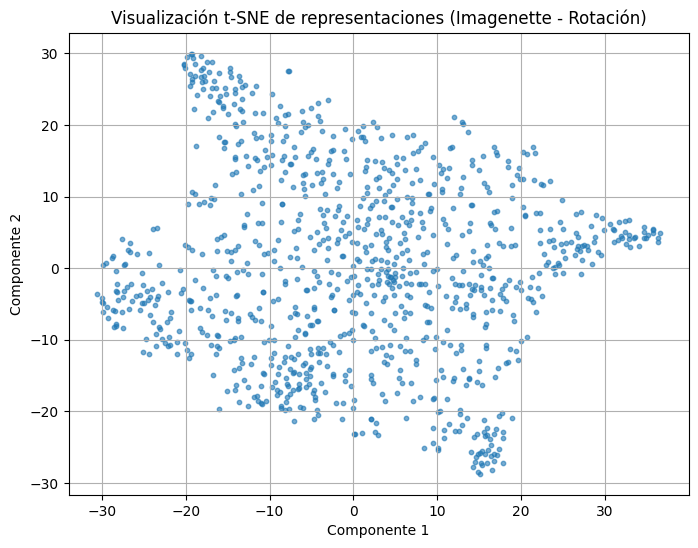

In [7]:
# Aplicar t-SNE a 1000 vectores de prueba
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
x_test_2d = tsne.fit_transform(x_test_feat[:1000])

# Dibujar sin clases reales (solo estructura)
plt.figure(figsize=(8, 6))
plt.scatter(x_test_2d[:, 0], x_test_2d[:, 1], s=10, alpha=0.6)
plt.title("Visualización t-SNE de representaciones (Imagenette - Rotación)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid(True)
plt.show()


In [ ]:
# Recargamos las imágenes con etiquetas reales
dataset_labeled = image_dataset_from_directory(
    "imagenette2-160/train",
    labels='inferred',
    image_size=(160, 160),
    shuffle=False,
    batch_size=None  # imágenes individuales
)

# Convertimos a listas para alinear con embeddings
images_labeled = list(dataset_labeled.take(5000))

# Separar imágenes y etiquetas
x_all = tf.stack([img for img, label in images_labeled])
y_all = np.array([label.numpy() for img, label in images_labeled])

# Normalizar
x_all = tf.cast(x_all, tf.float32) / 255.0


# Extraemos las etiquetas verdaderas (clases 0–9)
labels_labeled = np.array([label for _, label in dataset_labeled.take(5000)])

# Alineamos con los embeddings que ya habíamos separado en train/test
from sklearn.model_selection import train_test_split
x_train_real, x_test_real, y_train_real, y_test_real = train_test_split(
    x_all, y_all, test_size=0.2, random_state=42
)


Found 9469 files belonging to 10 classes.


In [ ]:
# Usar extractor para generar embeddings
x_train_feat = feature_extractor.predict(x_train_real)
x_test_feat = feature_extractor.predict(x_test_real)

# Clasificador
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(max_iter=1000)
clf.fit(x_train_feat, y_train_real)

y_pred = clf.predict(x_test_feat)
acc = accuracy_score(y_test_real, y_pred)

print(f"🎯 Precisión en clasificación downstream (Imagenette): {acc:.4f}")
